## たくさん新しく作った特徴量で、精度の最適化を図る！！

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')
kitchen_points = pd.read_csv('../data/handmade_data/kitchen_points.csv')
equipments = pd.read_csv('../data/handmade_data/equipments.csv')
bath_toilet_points = pd.read_csv('../data/handmade_data/bath_toilet_points.csv')
broadcasts = pd.read_csv('../data/handmade_data/broadcasts.csv')
parkings = pd.read_csv('../data/handmade_data/parkings.csv')
building = pd.read_csv('../data/handmade_data/building.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')
test_kitchen_points = pd.read_csv('../data/test_data/test_kitchen_points.csv')
test_equipments = pd.read_csv('../data/test_data/test_equipments.csv')
test_bath_toilet_points = pd.read_csv('../data/test_data/test_bath_toilet_points.csv')
test_broadcasts = pd.read_csv('../data/handmade_data/broadcasts.csv')
test_parkings = pd.read_csv('../data/test_data/test_parkings.csv')
test_building = pd.read_csv('../data/test_data/test_building.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, 
                    stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D","S"]], 
                    building, buildings,over100m2, bt75and100m2, bt50and75m2, area_per_rooms, 
                    kitchen_points, equipments, bath_toilet_points, broadcasts, parkings], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, 
                    test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'S']],
                    test_building, test_buildings,test_over100m2, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms,
                     test_kitchen_points, test_equipments, test_bath_toilet_points, test_broadcasts, test_parkings], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'S', 'バス・トイレ別','カテゴリ建物構造','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満', 
                    'ガスコンロ', 'コンロ2口', 'システムキッチン', '給湯', '独立キッチン', 'コンロ3口', 'IHコンロ', '電気コンロ',
                    'エアコン付','シューズボックス','バルコニー','フローリング','室内洗濯機置場',
                    '敷地内ごみ置き場','エレベーター','公営水道','水道その他','下水','汲み取り','都市ガス','プロパンガス','タイル張',
                    'ウォークインクローゼット','2面採光','3面採光','24時間換気システム','ペアガラス','庭','クッションフロア','床暖房','ロフト',
                    '出窓','トランクルーム','オール電化',
                    '専用バス','バス・トイレ別','シャワー','専用トイレ','浴室乾燥機','温水洗浄便座',
                    '洗面台独立','脱衣所','追焚機能',
                    'インターネット対応','catv','csアンテナ','bsアンテナ','光ファイバー',
                    '高速インターネット','インターネット使用料無料',
                    '駐車場空有','駐車場空無','駐車場無','駐車場近隣',
                    '駐輪場空有','駐輪場無','バイク置き場無','バイク置き場空有'
                    ]

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2870
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 77
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48819.7	valid_1's rmse: 50156.2


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '24時間換気システム', '2面採光', '3面採光', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'bsアンテナ', 'catv', 'csアンテナ', 'インターネット使用料無料', 'インターネット対応', 'ウォークインクローゼット', 'エアコン付', 'エレベーター', 'オール電化', 'カテゴリ建物構造', 'ガスコンロ', 'クッションフロア', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'シャワー', 'シューズボックス', 'タイル張', 'トランクルーム', 'バイク置き場無', 'バイク置き場空有', 'バス・トイレ別', 'バス・トイレ別', 'バルコニー', 'フローリング', 'プロパンガス', 'ペアガラス', 'ロフト', '下水', '光ファイバー', '

[20]	training's rmse: 34514.4	valid_1's rmse: 37763.5
[30]	training's rmse: 26076.4	valid_1's rmse: 30928.6
[40]	training's rmse: 21071.3	valid_1's rmse: 27129.8
[50]	training's rmse: 17797.1	valid_1's rmse: 24766.1
[60]	training's rmse: 15836.9	valid_1's rmse: 23333.5
[70]	training's rmse: 14392.7	valid_1's rmse: 22243.2
[80]	training's rmse: 13374.5	valid_1's rmse: 21539.9
[90]	training's rmse: 12599.1	valid_1's rmse: 21005
[100]	training's rmse: 11970.2	valid_1's rmse: 20578.4
[110]	training's rmse: 11398.6	valid_1's rmse: 20210.5
[120]	training's rmse: 10887.2	valid_1's rmse: 19854.5
[130]	training's rmse: 10470.2	valid_1's rmse: 19570.2
[140]	training's rmse: 10118.5	valid_1's rmse: 19346.6
[150]	training's rmse: 9773.13	valid_1's rmse: 19142.4
[160]	training's rmse: 9465.9	valid_1's rmse: 18958.7
[170]	training's rmse: 9167.68	valid_1's rmse: 18776.9
[180]	training's rmse: 8914.56	valid_1's rmse: 18612.6
[190]	training's rmse: 8695.55	valid_1's rmse: 18494.2
[200]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '24時間換気システム', '2面採光', '3面採光', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'bsアンテナ', 'catv', 'csアンテナ', 'インターネット使用料無料', 'インターネット対応', 'ウォークインクローゼット', 'エアコン付', 'エレベーター', 'オール電化', 'カテゴリ建物構造', 'ガスコンロ', 'クッションフロア', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'シャワー', 'シューズボックス', 'タイル張', 'トランクルーム', 'バイク置き場無', 'バイク置き場空有', 'バス・トイレ別', 'バス・トイレ別', 'バルコニー', 'フローリング', 'プロパンガス', 'ペアガラス', 'ロフト', '下水', '光ファイバー', '

[20]	training's rmse: 34867.3	valid_1's rmse: 35872.3
[30]	training's rmse: 26653.5	valid_1's rmse: 28214.2
[40]	training's rmse: 21873.5	valid_1's rmse: 24023.1
[50]	training's rmse: 18932.1	valid_1's rmse: 21393.6
[60]	training's rmse: 17115.1	valid_1's rmse: 19935.1
[70]	training's rmse: 15768.3	valid_1's rmse: 19083.6
[80]	training's rmse: 14737.9	valid_1's rmse: 18497.5
[90]	training's rmse: 13919.2	valid_1's rmse: 18213.3
[100]	training's rmse: 13256.9	valid_1's rmse: 18112.2
[110]	training's rmse: 12732.5	valid_1's rmse: 18022.2
[120]	training's rmse: 12224.8	valid_1's rmse: 17955.6
[130]	training's rmse: 11773.9	valid_1's rmse: 17864.6
[140]	training's rmse: 11345.5	valid_1's rmse: 17826
[150]	training's rmse: 10973.8	valid_1's rmse: 17839.1
Early stopping, best iteration is:
[143]	training's rmse: 11234.5	valid_1's rmse: 17790.3
Start training...


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '24時間換気システム', '2面採光', '3面採光', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'bsアンテナ', 'catv', 'csアンテナ', 'インターネット使用料無料', 'インターネット対応', 'ウォークインクローゼット', 'エアコン付', 'エレベーター', 'オール電化', 'カテゴリ建物構造', 'ガスコンロ', 'クッションフロア', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'シャワー', 'シューズボックス', 'タイル張', 'トランクルーム', 'バイク置き場無', 'バイク置き場空有', 'バス・トイレ別', 'バス・トイレ別', 'バルコニー', 'フローリング', 'プロパンガス', 'ペアガラス', 'ロフト', '下水', '光ファイバー', '

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 77
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48905.3	valid_1's rmse: 48944.7
[20]	training's rmse: 35041.8	valid_1's rmse: 34777.7
[30]	training's rmse: 26743.7	valid_1's rmse: 27007
[40]	training's rmse: 21952.9	valid_1's rmse: 22777.6
[50]	training's rmse: 18896.1	valid_1's rmse: 20264.5
[60]	training's rmse: 16999.9	valid_1's rmse: 18985.7
[70]	training's rmse: 15679.1	valid_1's rmse: 18218.1
[80]	training's rmse: 14683.8	valid_1's rmse: 17759
[90]	training's rmse: 13890.5	valid_1's rmse: 17419.6
[100]	training's rmse: 13234.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '24時間換気システム', '2面採光', '3面採光', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'bsアンテナ', 'catv', 'csアンテナ', 'インターネット使用料無料', 'インターネット対応', 'ウォークインクローゼット', 'エアコン付', 'エレベーター', 'オール電化', 'カテゴリ建物構造', 'ガスコンロ', 'クッションフロア', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'シャワー', 'シューズボックス', 'タイル張', 'トランクルーム', 'バイク置き場無', 'バイク置き場空有', 'バス・トイレ別', 'バス・トイレ別', 'バルコニー', 'フローリング', 'プロパンガス', 'ペアガラス', 'ロフト', '下水', '光ファイバー', '

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 77
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49044.5	valid_1's rmse: 48028.5
[20]	training's rmse: 34714.8	valid_1's rmse: 35706.2
[30]	training's rmse: 26281.5	valid_1's rmse: 28844
[40]	training's rmse: 21325	valid_1's rmse: 25198.8
[50]	training's rmse: 18268.7	valid_1's rmse: 23293.7
[60]	training's rmse: 16412.3	valid_1's rmse: 22300
[70]	training's rmse: 15105	valid_1's rmse: 21822.7
[80]	training's rmse: 14150.7	valid_1's rmse: 21460.7
[90]	training's rmse: 13424.4	valid_1's rmse: 21193.5
[100]	training's rmse: 12808.7	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '24時間換気システム', '2面採光', '3面採光', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'bsアンテナ', 'catv', 'csアンテナ', 'インターネット使用料無料', 'インターネット対応', 'ウォークインクローゼット', 'エアコン付', 'エレベーター', 'オール電化', 'カテゴリ建物構造', 'ガスコンロ', 'クッションフロア', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'シャワー', 'シューズボックス', 'タイル張', 'トランクルーム', 'バイク置き場無', 'バイク置き場空有', 'バス・トイレ別', 'バス・トイレ別', 'バルコニー', 'フローリング', 'プロパンガス', 'ペアガラス', 'ロフト', '下水', '光ファイバー', '

[10]	training's rmse: 48746.2	valid_1's rmse: 51230.9
[20]	training's rmse: 35081.7	valid_1's rmse: 37034.9
[30]	training's rmse: 26966.6	valid_1's rmse: 28494
[40]	training's rmse: 22285.8	valid_1's rmse: 23579.1
[50]	training's rmse: 19151.9	valid_1's rmse: 20862.7
[60]	training's rmse: 17173	valid_1's rmse: 19336.8
[70]	training's rmse: 15871.8	valid_1's rmse: 18450.2
[80]	training's rmse: 14860.8	valid_1's rmse: 17843.2
[90]	training's rmse: 14068.5	valid_1's rmse: 17446.5
[100]	training's rmse: 13440.7	valid_1's rmse: 17147.9
[110]	training's rmse: 12934.8	valid_1's rmse: 16950.2
[120]	training's rmse: 12492	valid_1's rmse: 16763.9
[130]	training's rmse: 12041	valid_1's rmse: 16580.7
[140]	training's rmse: 11643.9	valid_1's rmse: 16425.5
[150]	training's rmse: 11269	valid_1's rmse: 16271.6
[160]	training's rmse: 10902.4	valid_1's rmse: 16199.4
[170]	training's rmse: 10587.5	valid_1's rmse: 16121.2
[180]	training's rmse: 10303.3	valid_1's rmse: 16041.4
[190]	training's rmse: 10045.

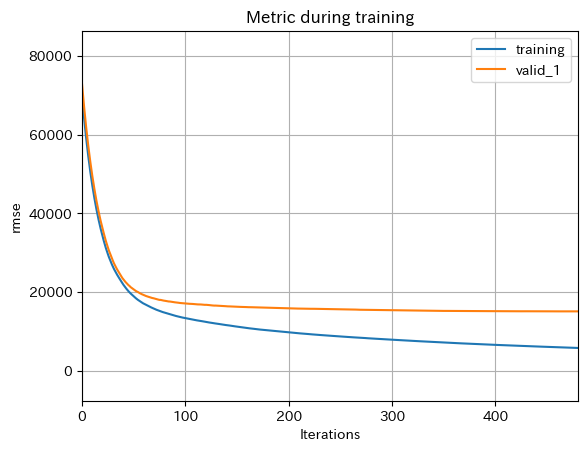

,importance
面積,4.425184e+14
L,3.940565e+14
平均地価,1.979675e+14
最寄り駅,9.500021e+13
築年数,5.805780e+13
...,...
庭,7.488594e+09
ペアガラス,7.196481e+09
クッションフロア,1.908112e+09
駐車場空無,1.178453e+09


In [141]:
n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  5.009615137983937e-06,
        'max_bin': 346,
        'num_leaves': 91,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

    pred_y_val = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

In [142]:
print("whole valid rmse:", valid_rmse)
df_importance[10:30]

whole valid rmse: 17004.477545770314


,importance
所在階,1.159372e+13
カテゴリ建物構造,8.322171e+12
所要時間,5.376752e+12
エレベーター,4.910645e+12
システムキッチン,4.636011e+12
床暖房,4.428937e+12
浴室乾燥機,3.716494e+12
部屋数,2.234268e+12
脱衣所,1.840502e+12
コンロ3口,1.835904e+12


### 重要度の低い順に特徴量を消してみる！

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
# sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
# sepa_bath_toilets.columns = ['バス・トイレ別']
# washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')
kitchen_points = pd.read_csv('../data/handmade_data/kitchen_points.csv')
# kitchen_points.drop(['ガスコンロ'],axis=1,inplace=True)
equipments = pd.read_csv('../data/handmade_data/equipments.csv')
equipments.drop(['汲み取り','ペアガラス','プロパンガス','フローリング','下水'],axis=1, inplace=True)
bath_toilet_points = pd.read_csv('../data/handmade_data/bath_toilet_points.csv')
# bath_toilet_points.drop('追焚機能',axis=1,inplace=True)
broadcasts = pd.read_csv('../data/handmade_data/broadcasts.csv')
broadcasts.drop(['高速インターネット'],axis=1,inplace=True)
parkings = pd.read_csv('../data/handmade_data/parkings.csv')
# parkings.drop('',axis=1,inplace=True)
building = pd.read_csv('../data/handmade_data/building.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
# test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
# test_sepa_bath_toilets.columns = ['バス・トイレ別']
# test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')
test_kitchen_points = pd.read_csv('../data/test_data/test_kitchen_points.csv')
# test_kitchen_points.drop(['ガスコンロ'],axis=1,inplace=True)
test_equipments = pd.read_csv('../data/test_data/test_equipments.csv')
test_equipments.drop(['汲み取り','ペアガラス','プロパンガス','フローリング','下水'],axis=1, inplace=True)
test_bath_toilet_points = pd.read_csv('../data/test_data/test_bath_toilet_points.csv')
# test_bath_toilet_points.drop('追焚機能',axis=1,inplace=True)
test_broadcasts = pd.read_csv('../data/handmade_data/broadcasts.csv')
test_broadcasts.drop(['高速インターネット'],axis=1,inplace=True)
test_parkings = pd.read_csv('../data/test_data/test_parkings.csv')
# test_parkings.drop('',axis=1,inplace=True)
test_building = pd.read_csv('../data/test_data/test_building.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, 
                    stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'S']], 
                    building, buildings,over100m2, bt75and100m2, bt50and75m2, area_per_rooms, 
                    kitchen_points, equipments, bath_toilet_points, broadcasts, parkings], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, 
                    test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'S']],
                    test_building, test_buildings,test_over100m2, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms,
                     test_kitchen_points, test_equipments, test_bath_toilet_points, test_broadcasts, test_parkings], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'S','カテゴリ建物構造','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満', 
                    'ガスコンロ', 'コンロ2口', '給湯','システムキッチン', '独立キッチン', 'コンロ3口', 'IHコンロ', '電気コンロ',
                    'エアコン付','シューズボックス','バルコニー','室内洗濯機置場',
                    '敷地内ごみ置き場','エレベーター','水道その他','都市ガス','タイル張',
                    'ウォークインクローゼット','2面採光','3面採光','24時間換気システム','クッションフロア','庭','床暖房','ロフト',
                    '出窓','トランクルーム','オール電化',
                    '専用バス','バス・トイレ別','シャワー','専用トイレ','浴室乾燥機','温水洗浄便座',
                    '洗面台独立','脱衣所','追焚機能',
                    'インターネット対応','catv','csアンテナ','bsアンテナ','光ファイバー',
                    'インターネット使用料無料',
                    '駐車場空有','駐車場空無','駐車場無','駐車場近隣',
                    '駐輪場空有','駐輪場無','バイク置き場無','バイク置き場空有'
                    ]

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2851
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 71
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48819.7	valid_1's rmse: 50156.2


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '24時間換気システム', '2面採光', '3面採光', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'bsアンテナ', 'catv', 'csアンテナ', 'インターネット使用料無料', 'インターネット対応', 'エアコン付', 'エレベーター', 'オール電化', 'カテゴリ建物構造', 'ガスコンロ', 'クッションフロア', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'シャワー', 'シューズボックス', 'タイル張', 'トランクルーム', 'バイク置き場無', 'バイク置き場空有', 'バス・トイレ別', 'バルコニー', 'ロフト', '光ファイバー', '出窓', '定期借家', '室内洗濯機置場', '専用トイレ', '専用バス', '床暖房', '庭', '建物構造', '

[20]	training's rmse: 34512.3	valid_1's rmse: 37768.5
[30]	training's rmse: 26050	valid_1's rmse: 30916.8
[40]	training's rmse: 21035.7	valid_1's rmse: 27043.1
[50]	training's rmse: 17772.1	valid_1's rmse: 24704.6
[60]	training's rmse: 15772.8	valid_1's rmse: 23225.5
[70]	training's rmse: 14338.3	valid_1's rmse: 22171
[80]	training's rmse: 13381.3	valid_1's rmse: 21494.2
[90]	training's rmse: 12602.6	valid_1's rmse: 20989.9
[100]	training's rmse: 11952.1	valid_1's rmse: 20576.6
[110]	training's rmse: 11386.5	valid_1's rmse: 20193.4
[120]	training's rmse: 10911.9	valid_1's rmse: 19851.5
[130]	training's rmse: 10482	valid_1's rmse: 19604.8
[140]	training's rmse: 10131.8	valid_1's rmse: 19401.6
[150]	training's rmse: 9818.34	valid_1's rmse: 19228.9
[160]	training's rmse: 9491.95	valid_1's rmse: 19004.8
[170]	training's rmse: 9224.26	valid_1's rmse: 18846.4
[180]	training's rmse: 8983.5	valid_1's rmse: 18696.4
[190]	training's rmse: 8733.68	valid_1's rmse: 18536.4
[200]	training's rmse: 85

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '24時間換気システム', '2面採光', '3面採光', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'bsアンテナ', 'catv', 'csアンテナ', 'インターネット使用料無料', 'インターネット対応', 'エアコン付', 'エレベーター', 'オール電化', 'カテゴリ建物構造', 'ガスコンロ', 'クッションフロア', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'シャワー', 'シューズボックス', 'タイル張', 'トランクルーム', 'バイク置き場無', 'バイク置き場空有', 'バス・トイレ別', 'バルコニー', 'ロフト', '光ファイバー', '出窓', '定期借家', '室内洗濯機置場', '専用トイレ', '専用バス', '床暖房', '庭', '建物構造', '

[20]	training's rmse: 34856.2	valid_1's rmse: 35881.2
[30]	training's rmse: 26671.3	valid_1's rmse: 28271.6
[40]	training's rmse: 21930.5	valid_1's rmse: 23977
[50]	training's rmse: 18968.4	valid_1's rmse: 21323.1
[60]	training's rmse: 17153	valid_1's rmse: 19922.1
[70]	training's rmse: 15824.4	valid_1's rmse: 19138.3
[80]	training's rmse: 14820.1	valid_1's rmse: 18660.5
[90]	training's rmse: 13976.5	valid_1's rmse: 18388.1
[100]	training's rmse: 13295.2	valid_1's rmse: 18241.6
[110]	training's rmse: 12728.6	valid_1's rmse: 18145.7
[120]	training's rmse: 12251.4	valid_1's rmse: 18047.4
[130]	training's rmse: 11775.6	valid_1's rmse: 17974.6
[140]	training's rmse: 11372.1	valid_1's rmse: 17996.3
[150]	training's rmse: 10984.1	valid_1's rmse: 17908.1
[160]	training's rmse: 10647.9	valid_1's rmse: 17914.9
Early stopping, best iteration is:
[154]	training's rmse: 10840.2	valid_1's rmse: 17890.8
Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of te

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '24時間換気システム', '2面採光', '3面採光', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'bsアンテナ', 'catv', 'csアンテナ', 'インターネット使用料無料', 'インターネット対応', 'エアコン付', 'エレベーター', 'オール電化', 'カテゴリ建物構造', 'ガスコンロ', 'クッションフロア', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'シャワー', 'シューズボックス', 'タイル張', 'トランクルーム', 'バイク置き場無', 'バイク置き場空有', 'バス・トイレ別', 'バルコニー', 'ロフト', '光ファイバー', '出窓', '定期借家', '室内洗濯機置場', '専用トイレ', '専用バス', '床暖房', '庭', '建物構造', '

[10]	training's rmse: 48905.3	valid_1's rmse: 48944.7
[20]	training's rmse: 34982.3	valid_1's rmse: 34726
[30]	training's rmse: 26703.6	valid_1's rmse: 27091
[40]	training's rmse: 21972.2	valid_1's rmse: 22936.5
[50]	training's rmse: 18927.1	valid_1's rmse: 20444.3
[60]	training's rmse: 17021.6	valid_1's rmse: 19226.8
[70]	training's rmse: 15717.8	valid_1's rmse: 18506.3
[80]	training's rmse: 14709.1	valid_1's rmse: 18084.2
[90]	training's rmse: 13899.2	valid_1's rmse: 17812.1
[100]	training's rmse: 13270.5	valid_1's rmse: 17653.7
[110]	training's rmse: 12726.5	valid_1's rmse: 17517.7
[120]	training's rmse: 12218	valid_1's rmse: 17408.3
[130]	training's rmse: 11748	valid_1's rmse: 17302.7
[140]	training's rmse: 11338.9	valid_1's rmse: 17267.5
[150]	training's rmse: 10974.9	valid_1's rmse: 17233.5
[160]	training's rmse: 10634.1	valid_1's rmse: 17201.4
Early stopping, best iteration is:
[159]	training's rmse: 10671.8	valid_1's rmse: 17198.4
Start training...
[LightGBM] [Warning] Auto-cho

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '24時間換気システム', '2面採光', '3面採光', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'bsアンテナ', 'catv', 'csアンテナ', 'インターネット使用料無料', 'インターネット対応', 'エアコン付', 'エレベーター', 'オール電化', 'カテゴリ建物構造', 'ガスコンロ', 'クッションフロア', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'シャワー', 'シューズボックス', 'タイル張', 'トランクルーム', 'バイク置き場無', 'バイク置き場空有', 'バス・トイレ別', 'バルコニー', 'ロフト', '光ファイバー', '出窓', '定期借家', '室内洗濯機置場', '専用トイレ', '専用バス', '床暖房', '庭', '建物構造', '

[10]	training's rmse: 49044.6	valid_1's rmse: 48033.5
[20]	training's rmse: 34708.1	valid_1's rmse: 35726.9
[30]	training's rmse: 26186.3	valid_1's rmse: 28904.2
[40]	training's rmse: 21293.9	valid_1's rmse: 25303.3
[50]	training's rmse: 18283.5	valid_1's rmse: 23420.9
[60]	training's rmse: 16442	valid_1's rmse: 22449.2
[70]	training's rmse: 15086.7	valid_1's rmse: 21969.6
[80]	training's rmse: 14167.6	valid_1's rmse: 21653.1
[90]	training's rmse: 13442.3	valid_1's rmse: 21327.5
[100]	training's rmse: 12845.6	valid_1's rmse: 21123.5
[110]	training's rmse: 12307.8	valid_1's rmse: 20910.5
[120]	training's rmse: 11857.1	valid_1's rmse: 20790
[130]	training's rmse: 11440.7	valid_1's rmse: 20673.9
[140]	training's rmse: 11085.8	valid_1's rmse: 20640.3
[150]	training's rmse: 10754.8	valid_1's rmse: 20569.1
[160]	training's rmse: 10451.8	valid_1's rmse: 20571.4
[170]	training's rmse: 10145.5	valid_1's rmse: 20526.1
[180]	training's rmse: 9889.41	valid_1's rmse: 20490.1
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '24時間換気システム', '2面採光', '3面採光', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'bsアンテナ', 'catv', 'csアンテナ', 'インターネット使用料無料', 'インターネット対応', 'エアコン付', 'エレベーター', 'オール電化', 'カテゴリ建物構造', 'ガスコンロ', 'クッションフロア', 'コンロ2口', 'コンロ3口', 'システムキッチン', 'シャワー', 'シューズボックス', 'タイル張', 'トランクルーム', 'バイク置き場無', 'バイク置き場空有', 'バス・トイレ別', 'バルコニー', 'ロフト', '光ファイバー', '出窓', '定期借家', '室内洗濯機置場', '専用トイレ', '専用バス', '床暖房', '庭', '建物構造', '

[20]	training's rmse: 35042.7	valid_1's rmse: 36961.1
[30]	training's rmse: 27001.4	valid_1's rmse: 28585.1
[40]	training's rmse: 22266.9	valid_1's rmse: 23688.3
[50]	training's rmse: 19079.8	valid_1's rmse: 20910.5
[60]	training's rmse: 17078.3	valid_1's rmse: 19449.1
[70]	training's rmse: 15779	valid_1's rmse: 18564.4
[80]	training's rmse: 14770.7	valid_1's rmse: 18033.4
[90]	training's rmse: 14000.5	valid_1's rmse: 17651.1
[100]	training's rmse: 13395.6	valid_1's rmse: 17388.3
[110]	training's rmse: 12875	valid_1's rmse: 17199.6
[120]	training's rmse: 12415.8	valid_1's rmse: 17015.3
[130]	training's rmse: 11966.8	valid_1's rmse: 16816.7
[140]	training's rmse: 11573.5	valid_1's rmse: 16667.3
[150]	training's rmse: 11196.8	valid_1's rmse: 16529.5
[160]	training's rmse: 10865	valid_1's rmse: 16459.8
[170]	training's rmse: 10559.2	valid_1's rmse: 16368.2
[180]	training's rmse: 10272	valid_1's rmse: 16262.1
[190]	training's rmse: 10023	valid_1's rmse: 16184.3
[200]	training's rmse: 9783.

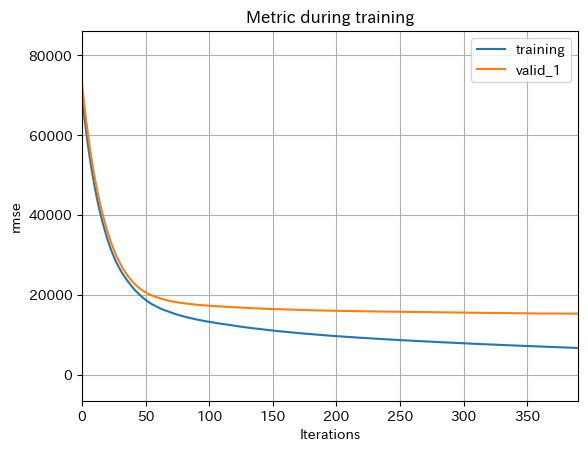

,importance
面積,4.483884e+14
L,3.884034e+14
平均地価,1.962171e+14
最寄り駅,9.484412e+13
築年数,5.875473e+13
...,...
電気コンロ,8.105555e+09
庭,6.617924e+09
オール電化,5.197798e+09
クッションフロア,3.611009e+09


In [159]:
n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  5.009615137983937e-06,
        'max_bin': 346,
        'num_leaves': 91,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

    pred_y_val = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

あった方が良い特徴量：「駐車場空無」「クッションフロア」「庭」「オール電化」「電気コンロ」「水道その他」「エアコン付」「出窓」「S」[3面採光]「駐車場近隣」「専用トイレ」
「駐車場無」「専用バス」「独立キッチン」「駐輪場無」「シューズボックス」「インターネット使用料無料」「トランクルーム」「ロフト」「2面採光」「シャワー」「敷地内ごみ置き場」「バルコニー」「都市ガス」「バイク置き場無」「室内洗濯機置場」「公営水道」「24時間換気システム」「給湯」「駐輪場空有」「IHコンロ」「バイク置き場空有」「タイル張り」「コンロ２口」「インターネット対応」「建物構造」「catv」「追焚機能」「D」「光ファイバー」「ガスコンロ」「csアンテナ」「駐車場空有」「bsアンテナ」「ウォークインクローゼット」

ない方が良い特徴量：「汲み取り」「ペアガラス」「プロパンガス」「高速インターネット」「フローリング」「下水」

### 定期借家までやった！

「床暖房」だけ入れてみたらスコアは良くなるか？

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
# sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
# sepa_bath_toilets.columns = ['バス・トイレ別']
# washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')
kitchen_points = pd.read_csv('../data/handmade_data/kitchen_points.csv')
# kitchen_points.drop(['ガスコンロ'],axis=1,inplace=True)
equipments = pd.read_csv('../data/handmade_data/equipments.csv')
equipments.drop(['汲み取り','ペアガラス','プロパンガス','フローリング','下水'],axis=1, inplace=True)
bath_toilet_points = pd.read_csv('../data/handmade_data/bath_toilet_points.csv')
# bath_toilet_points.drop('追焚機能',axis=1,inplace=True)
broadcasts = pd.read_csv('../data/handmade_data/broadcasts.csv')
broadcasts.drop(['高速インターネット'],axis=1,inplace=True)
parkings = pd.read_csv('../data/handmade_data/parkings.csv')
# parkings.drop('',axis=1,inplace=True)
building = pd.read_csv('../data/handmade_data/building.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
# test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
# test_sepa_bath_toilets.columns = ['バス・トイレ別']
# test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')
test_kitchen_points = pd.read_csv('../data/test_data/test_kitchen_points.csv')
# test_kitchen_points.drop(['ガスコンロ'],axis=1,inplace=True)
test_equipments = pd.read_csv('../data/test_data/test_equipments.csv')
test_equipments.drop(['汲み取り','ペアガラス','プロパンガス','フローリング','下水'],axis=1, inplace=True)
test_bath_toilet_points = pd.read_csv('../data/test_data/test_bath_toilet_points.csv')
# test_bath_toilet_points.drop('追焚機能',axis=1,inplace=True)
test_broadcasts = pd.read_csv('../data/handmade_data/broadcasts.csv')
test_broadcasts.drop(['高速インターネット'],axis=1,inplace=True)
test_parkings = pd.read_csv('../data/test_data/test_parkings.csv')
# test_parkings.drop('',axis=1,inplace=True)
test_building = pd.read_csv('../data/test_data/test_building.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, 
                    stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'S']], 
                    building, buildings,over100m2, bt75and100m2, bt50and75m2, area_per_rooms, 
                    equipments['床暖房']], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, 
                    test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'S']],
                    test_building, test_buildings,test_over100m2, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms,
                    test_equipments['床暖房']], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'S','カテゴリ建物構造','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満', 
                    '床暖房'
                    ]

Duplicate key in file PosixPath('/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc'), line 258 ('font.family : IPAexGothic')


Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2703
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48805.8	valid_1's rmse: 50157.8
[20]	training's rmse: 34511.3	valid_1's rmse: 37750


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'カテゴリ建物構造', '定期借家', '床暖房', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callb

[30]	training's rmse: 26037.2	valid_1's rmse: 30770.8
[40]	training's rmse: 21094.2	valid_1's rmse: 26969.3
[50]	training's rmse: 17893	valid_1's rmse: 24661.3
[60]	training's rmse: 15924.6	valid_1's rmse: 23248.6
[70]	training's rmse: 14543.9	valid_1's rmse: 22271
[80]	training's rmse: 13546.3	valid_1's rmse: 21545.6
[90]	training's rmse: 12801.5	valid_1's rmse: 21015.8
[100]	training's rmse: 12158.8	valid_1's rmse: 20592.4
[110]	training's rmse: 11615.3	valid_1's rmse: 20197.7
[120]	training's rmse: 11133.2	valid_1's rmse: 19890.7
[130]	training's rmse: 10739	valid_1's rmse: 19616.3
[140]	training's rmse: 10388.3	valid_1's rmse: 19363.8
[150]	training's rmse: 10094.4	valid_1's rmse: 19149
[160]	training's rmse: 9783.29	valid_1's rmse: 18930.7
[170]	training's rmse: 9541.51	valid_1's rmse: 18759.4
[180]	training's rmse: 9316.17	valid_1's rmse: 18579
[190]	training's rmse: 9111.86	valid_1's rmse: 18429.2
[200]	training's rmse: 8915.25	valid_1's rmse: 18293.8
[210]	training's rmse: 8734

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'カテゴリ建物構造', '定期借家', '床暖房', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callb

[30]	training's rmse: 26797.9	valid_1's rmse: 28247.9
[40]	training's rmse: 22004.6	valid_1's rmse: 24005.5
[50]	training's rmse: 19067.9	valid_1's rmse: 21393.6
[60]	training's rmse: 17243.4	valid_1's rmse: 19866.9
[70]	training's rmse: 15954.1	valid_1's rmse: 19023.9
[80]	training's rmse: 14922.4	valid_1's rmse: 18408.9
[90]	training's rmse: 14110.2	valid_1's rmse: 18043.3
[100]	training's rmse: 13461.1	valid_1's rmse: 17781.7
[110]	training's rmse: 12883.9	valid_1's rmse: 17595.6
[120]	training's rmse: 12422	valid_1's rmse: 17486.7
[130]	training's rmse: 11998.6	valid_1's rmse: 17435.3
[140]	training's rmse: 11591.2	valid_1's rmse: 17380.1
[150]	training's rmse: 11206.7	valid_1's rmse: 17331.1
[160]	training's rmse: 10885.3	valid_1's rmse: 17315.3
[170]	training's rmse: 10572.3	valid_1's rmse: 17293.6
[180]	training's rmse: 10281.8	valid_1's rmse: 17292.3
Early stopping, best iteration is:
[172]	training's rmse: 10520.3	valid_1's rmse: 17281.6
Start training...
[LightGBM] [Warning] 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'カテゴリ建物構造', '定期借家', '床暖房', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callb

[20]	training's rmse: 34983.2	valid_1's rmse: 34792.2
[30]	training's rmse: 26757.9	valid_1's rmse: 27182.6
[40]	training's rmse: 22024.1	valid_1's rmse: 23011.4
[50]	training's rmse: 19052.2	valid_1's rmse: 20582.9
[60]	training's rmse: 17163.9	valid_1's rmse: 19305.3
[70]	training's rmse: 15899.3	valid_1's rmse: 18627.5
[80]	training's rmse: 14935.4	valid_1's rmse: 18193.7
[90]	training's rmse: 14155	valid_1's rmse: 17925.8
[100]	training's rmse: 13493.4	valid_1's rmse: 17746.5
[110]	training's rmse: 12966.4	valid_1's rmse: 17569.9
[120]	training's rmse: 12483	valid_1's rmse: 17445
[130]	training's rmse: 12073.1	valid_1's rmse: 17348.1
[140]	training's rmse: 11671.8	valid_1's rmse: 17270
[150]	training's rmse: 11328.7	valid_1's rmse: 17212.2
[160]	training's rmse: 10989.8	valid_1's rmse: 17159.9
[170]	training's rmse: 10678.9	valid_1's rmse: 17114.4
[180]	training's rmse: 10406.2	valid_1's rmse: 17095.8
[190]	training's rmse: 10145.5	valid_1's rmse: 17070.2
[200]	training's rmse: 990

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'カテゴリ建物構造', '定期借家', '床暖房', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callb

[30]	training's rmse: 26206.4	valid_1's rmse: 28672.2
[40]	training's rmse: 21374.8	valid_1's rmse: 24979.7
[50]	training's rmse: 18321.1	valid_1's rmse: 23039
[60]	training's rmse: 16517.1	valid_1's rmse: 22022.2
[70]	training's rmse: 15234.2	valid_1's rmse: 21479.8
[80]	training's rmse: 14332.8	valid_1's rmse: 21038.7
[90]	training's rmse: 13628.7	valid_1's rmse: 20713
[100]	training's rmse: 13030.2	valid_1's rmse: 20448.7
[110]	training's rmse: 12536.3	valid_1's rmse: 20340.7
[120]	training's rmse: 12080.5	valid_1's rmse: 20160
[130]	training's rmse: 11676.3	valid_1's rmse: 20013.8
[140]	training's rmse: 11340.7	valid_1's rmse: 19938.5
[150]	training's rmse: 11024.3	valid_1's rmse: 19815.7
[160]	training's rmse: 10728.6	valid_1's rmse: 19770.2
[170]	training's rmse: 10461	valid_1's rmse: 19675.9
[180]	training's rmse: 10188.4	valid_1's rmse: 19582.9
[190]	training's rmse: 9946.72	valid_1's rmse: 19526.6
[200]	training's rmse: 9733.25	valid_1's rmse: 19488.5
[210]	training's rmse: 95

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'カテゴリ建物構造', '定期借家', '床暖房', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callb

[20]	training's rmse: 35115	valid_1's rmse: 37040.3
[30]	training's rmse: 27063.9	valid_1's rmse: 28703.3
[40]	training's rmse: 22372.9	valid_1's rmse: 23607.6
[50]	training's rmse: 19235	valid_1's rmse: 20814.8
[60]	training's rmse: 17290.5	valid_1's rmse: 19305.5
[70]	training's rmse: 16016	valid_1's rmse: 18307.3
[80]	training's rmse: 15038.3	valid_1's rmse: 17701
[90]	training's rmse: 14274.5	valid_1's rmse: 17331.8
[100]	training's rmse: 13653.4	valid_1's rmse: 17002.9
[110]	training's rmse: 13159.9	valid_1's rmse: 16796.4
[120]	training's rmse: 12707.4	valid_1's rmse: 16674.1
[130]	training's rmse: 12321.3	valid_1's rmse: 16544.7
[140]	training's rmse: 11927.8	valid_1's rmse: 16417
[150]	training's rmse: 11558.5	valid_1's rmse: 16319.8
[160]	training's rmse: 11222.5	valid_1's rmse: 16184.4
[170]	training's rmse: 10939.3	valid_1's rmse: 16122.3
[180]	training's rmse: 10657.6	valid_1's rmse: 16024.2
[190]	training's rmse: 10401.3	valid_1's rmse: 15916.8
[200]	training's rmse: 10166

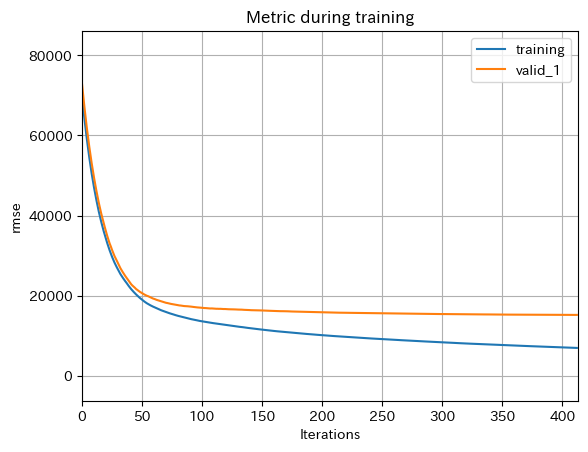

,importance
面積,4.568984e+14
L,3.935519e+14
平均地価,2.008632e+14
最寄り駅,9.546284e+13
築年数,6.973570e+13
所在地,3.398855e+13
一部屋あたりの面積,2.531185e+13
全体の階数,2.258842e+13
契約期間,1.398749e+13
カテゴリ建物構造,1.260321e+13


In [2]:
n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  5.009615137983937e-06,
        'max_bin': 346,
        'num_leaves': 91,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

    pred_y_val = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

「床暖房」だけでは良くならない！

「キッチン」の情報を足してみたらどうか？

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
# sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
# sepa_bath_toilets.columns = ['バス・トイレ別']
# washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')
kitchen_points = pd.read_csv('../data/handmade_data/kitchen_points.csv')
# kitchen_points.drop(['ガスコンロ'],axis=1,inplace=True)
equipments = pd.read_csv('../data/handmade_data/equipments.csv')
equipments.drop(['汲み取り','ペアガラス','プロパンガス','フローリング','下水'],axis=1, inplace=True)
bath_toilet_points = pd.read_csv('../data/handmade_data/bath_toilet_points.csv')
# bath_toilet_points.drop('追焚機能',axis=1,inplace=True)
broadcasts = pd.read_csv('../data/handmade_data/broadcasts.csv')
broadcasts.drop(['高速インターネット'],axis=1,inplace=True)
parkings = pd.read_csv('../data/handmade_data/parkings.csv')
# parkings.drop('',axis=1,inplace=True)
building = pd.read_csv('../data/handmade_data/building.csv')
equipments = pd.read_csv('../data/handmade_data/equipments.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
# test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
# test_sepa_bath_toilets.columns = ['バス・トイレ別']
# test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')
test_kitchen_points = pd.read_csv('../data/test_data/test_kitchen_points.csv')
# test_kitchen_points.drop(['ガスコンロ'],axis=1,inplace=True)
test_equipments = pd.read_csv('../data/test_data/test_equipments.csv')
test_equipments.drop(['汲み取り','ペアガラス','プロパンガス','フローリング','下水'],axis=1, inplace=True)
test_bath_toilet_points = pd.read_csv('../data/test_data/test_bath_toilet_points.csv')
# test_bath_toilet_points.drop('追焚機能',axis=1,inplace=True)
test_broadcasts = pd.read_csv('../data/handmade_data/broadcasts.csv')
test_broadcasts.drop(['高速インターネット'],axis=1,inplace=True)
test_parkings = pd.read_csv('../data/test_data/test_parkings.csv')
# test_parkings.drop('',axis=1,inplace=True)
test_building = pd.read_csv('../data/test_data/test_building.csv')
test_equipments = pd.read_csv('../data/test_data/test_equipments.csv')

X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, 
                    stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'S']], 
                    building, buildings,over100m2, bt75and100m2, bt50and75m2, area_per_rooms, 
                    kitchen_points,
                    equipments['床暖房']], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, 
                    test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'S']],
                    test_building, test_buildings,test_over100m2, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms,
                    test_kitchen_points,
                    test_equipments['床暖房']], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'S','カテゴリ建物構造','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満', 
                    'ガスコンロ', 'コンロ2口', '給湯','システムキッチン', '独立キッチン', 'コンロ3口', 'IHコンロ', '電気コンロ',
                    '床暖房'
                    ]

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2727
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 29
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48809.4	valid_1's rmse: 50159
[20]	training's rmse: 34461.2	valid_1's rmse: 37790


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'カテゴリ建物構造', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', '定期借家', '床暖房', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will 

[30]	training's rmse: 25998	valid_1's rmse: 30936.1
[40]	training's rmse: 21029.7	valid_1's rmse: 27083.9
[50]	training's rmse: 17842.3	valid_1's rmse: 24747.8
[60]	training's rmse: 15861.5	valid_1's rmse: 23348.3
[70]	training's rmse: 14479	valid_1's rmse: 22275.3
[80]	training's rmse: 13502.6	valid_1's rmse: 21571.8
[90]	training's rmse: 12675.6	valid_1's rmse: 20994.3
[100]	training's rmse: 12042.5	valid_1's rmse: 20561.9
[110]	training's rmse: 11491.7	valid_1's rmse: 20210.1
[120]	training's rmse: 11070.9	valid_1's rmse: 19884.7
[130]	training's rmse: 10650.6	valid_1's rmse: 19569.6
[140]	training's rmse: 10309.8	valid_1's rmse: 19342.5
[150]	training's rmse: 9986.84	valid_1's rmse: 19085.5
[160]	training's rmse: 9681.98	valid_1's rmse: 18833
[170]	training's rmse: 9435.33	valid_1's rmse: 18658.5
[180]	training's rmse: 9183.77	valid_1's rmse: 18489.5
[190]	training's rmse: 8976.53	valid_1's rmse: 18371.7
[200]	training's rmse: 8777.94	valid_1's rmse: 18250.1
[210]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'カテゴリ建物構造', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', '定期借家', '床暖房', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will 

[20]	training's rmse: 34933.4	valid_1's rmse: 35766.6
[30]	training's rmse: 26722.2	valid_1's rmse: 28211
[40]	training's rmse: 21971.9	valid_1's rmse: 24051.5
[50]	training's rmse: 19100.3	valid_1's rmse: 21549.4
[60]	training's rmse: 17292.4	valid_1's rmse: 20053.5
[70]	training's rmse: 15986	valid_1's rmse: 19162.4
[80]	training's rmse: 14931.4	valid_1's rmse: 18504.8
[90]	training's rmse: 14125.3	valid_1's rmse: 18076.5
[100]	training's rmse: 13459.8	valid_1's rmse: 17821.7
[110]	training's rmse: 12931.1	valid_1's rmse: 17685.6
[120]	training's rmse: 12431.6	valid_1's rmse: 17627.7
[130]	training's rmse: 12005.5	valid_1's rmse: 17541.9
[140]	training's rmse: 11599.5	valid_1's rmse: 17484.6
[150]	training's rmse: 11229.2	valid_1's rmse: 17481.8
[160]	training's rmse: 10861.1	valid_1's rmse: 17449.8
[170]	training's rmse: 10546.4	valid_1's rmse: 17429.8
[180]	training's rmse: 10248.1	valid_1's rmse: 17406.1
[190]	training's rmse: 9975.58	valid_1's rmse: 17410.7
Early stopping, best i

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'カテゴリ建物構造', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', '定期借家', '床暖房', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will 

[30]	training's rmse: 26754.2	valid_1's rmse: 27131.5
[40]	training's rmse: 21968.8	valid_1's rmse: 22966.2
[50]	training's rmse: 18976.1	valid_1's rmse: 20407.4
[60]	training's rmse: 17080.4	valid_1's rmse: 19161.4
[70]	training's rmse: 15793.7	valid_1's rmse: 18421
[80]	training's rmse: 14817.4	valid_1's rmse: 18013.5
[90]	training's rmse: 13996.8	valid_1's rmse: 17732.8
[100]	training's rmse: 13368.2	valid_1's rmse: 17578.2
[110]	training's rmse: 12836.5	valid_1's rmse: 17492.5
[120]	training's rmse: 12358.2	valid_1's rmse: 17312.7
[130]	training's rmse: 11915.7	valid_1's rmse: 17242.1
[140]	training's rmse: 11503.2	valid_1's rmse: 17161.7
[150]	training's rmse: 11153.4	valid_1's rmse: 17121
[160]	training's rmse: 10828.3	valid_1's rmse: 17074.4
[170]	training's rmse: 10520.7	valid_1's rmse: 17045.9
[180]	training's rmse: 10245.7	valid_1's rmse: 17012.7
[190]	training's rmse: 9986.72	valid_1's rmse: 16981.8
[200]	training's rmse: 9749.88	valid_1's rmse: 16971.1
[210]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'カテゴリ建物構造', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', '定期借家', '床暖房', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will 

[10]	training's rmse: 48989.7	valid_1's rmse: 47960.1
[20]	training's rmse: 34705.9	valid_1's rmse: 35641.6
[30]	training's rmse: 26168.1	valid_1's rmse: 28689.4
[40]	training's rmse: 21261.3	valid_1's rmse: 24985.7
[50]	training's rmse: 18214.3	valid_1's rmse: 23108.3
[60]	training's rmse: 16369	valid_1's rmse: 22014.5
[70]	training's rmse: 15139.9	valid_1's rmse: 21472.8
[80]	training's rmse: 14255	valid_1's rmse: 21113
[90]	training's rmse: 13538.9	valid_1's rmse: 20792.8
[100]	training's rmse: 12935.4	valid_1's rmse: 20525.8
[110]	training's rmse: 12440.5	valid_1's rmse: 20362.2
[120]	training's rmse: 11993.6	valid_1's rmse: 20244.6
[130]	training's rmse: 11594.4	valid_1's rmse: 20118.4
[140]	training's rmse: 11224.8	valid_1's rmse: 19991.1
[150]	training's rmse: 10891	valid_1's rmse: 19914.8
[160]	training's rmse: 10583.7	valid_1's rmse: 19812.3
[170]	training's rmse: 10304.1	valid_1's rmse: 19759.1
[180]	training's rmse: 10045.5	valid_1's rmse: 19716.7
[190]	training's rmse: 9815

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'カテゴリ建物構造', 'ガスコンロ', 'コンロ2口', 'コンロ3口', 'システムキッチン', '定期借家', '床暖房', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will 

[20]	training's rmse: 35094.7	valid_1's rmse: 37058.5
[30]	training's rmse: 26973.4	valid_1's rmse: 28564
[40]	training's rmse: 22235.9	valid_1's rmse: 23464.9
[50]	training's rmse: 19085	valid_1's rmse: 20667.3
[60]	training's rmse: 17163.9	valid_1's rmse: 19162.9
[70]	training's rmse: 15849.1	valid_1's rmse: 18265.8
[80]	training's rmse: 14840.1	valid_1's rmse: 17673.6
[90]	training's rmse: 14086.6	valid_1's rmse: 17296.3
[100]	training's rmse: 13449.4	valid_1's rmse: 17002.5
[110]	training's rmse: 12960.8	valid_1's rmse: 16808
[120]	training's rmse: 12527.3	valid_1's rmse: 16648.5
[130]	training's rmse: 12139.3	valid_1's rmse: 16459.5
[140]	training's rmse: 11760.5	valid_1's rmse: 16333.3
[150]	training's rmse: 11398	valid_1's rmse: 16173.6
[160]	training's rmse: 11066.3	valid_1's rmse: 16032.4
[170]	training's rmse: 10770.4	valid_1's rmse: 15958.5
[180]	training's rmse: 10500.6	valid_1's rmse: 15878.4
[190]	training's rmse: 10242.2	valid_1's rmse: 15788.2
[200]	training's rmse: 100

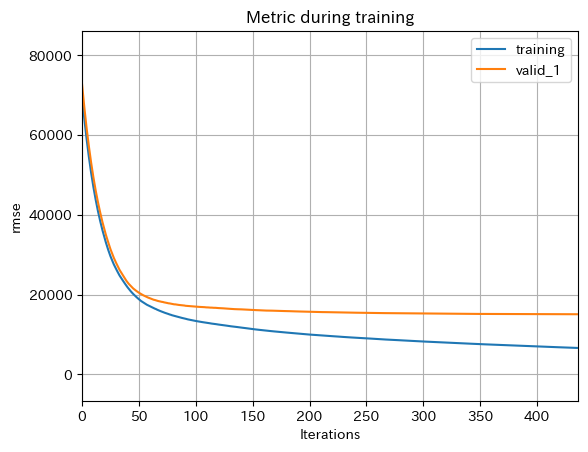

,importance
面積,4.521176e+14
L,3.946101e+14
平均地価,2.002604e+14
最寄り駅,9.223565e+13
築年数,6.755783e+13
所在地,3.573527e+13
一部屋あたりの面積,2.606611e+13
全体の階数,2.155574e+13
契約期間,1.420857e+13
カテゴリ建物構造,1.176178e+13


In [5]:
n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  5.009615137983937e-06,
        'max_bin': 346,
        'num_leaves': 91,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

    pred_y_val = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

「床暖房情報」はいらない模様

その他、他の情報と色々組み合わせる！「キッチン」情報の中からも減らしたりする！

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
building = pd.read_csv('../data/handmade_data/building.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')
kitchen_points = pd.read_csv('../data/handmade_data/kitchen_points.csv')
kitchen_points.drop('コンロ3口', axis=1, inplace=True)
equipments = pd.read_csv('../data/handmade_data/equipments.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_building = pd.read_csv('../data/test_data/test_building.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')
test_kitchen_points = pd.read_csv('../data/test_data/test_kitchen_points.csv')
test_kitchen_points.drop('コンロ3口', axis=1, inplace=True)
test_equipments = pd.read_csv('../data/test_data/test_equipments.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D","S"]], sepa_bath_toilets, buildings, over100m2, bt75and100m2, bt50and75m2, area_per_rooms, kitchen_points], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'S']],test_sepa_bath_toilets, test_buildings, test_over100m2, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms, test_kitchen_points], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'S', 'バス・トイレ別','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満', 'ガスコンロ','コンロ2口', 'システムキッチン', '給湯', '独立キッチン', 'IHコンロ','電気コンロ']

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2714
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 27
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48835.1	valid_1's rmse: 50190.2
[20]	training's rmse: 34621.3	valid_1's rmse: 37936


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a f

[30]	training's rmse: 26177.2	valid_1's rmse: 31063.3
[40]	training's rmse: 21090.8	valid_1's rmse: 27155.4
[50]	training's rmse: 17848.2	valid_1's rmse: 24730.3
[60]	training's rmse: 15867.6	valid_1's rmse: 23215.1
[70]	training's rmse: 14467.1	valid_1's rmse: 22177.5
[80]	training's rmse: 13553.5	valid_1's rmse: 21534.5
[90]	training's rmse: 12757.2	valid_1's rmse: 20998.9
[100]	training's rmse: 12081.4	valid_1's rmse: 20528.9
[110]	training's rmse: 11534.2	valid_1's rmse: 20154.4
[120]	training's rmse: 11111.1	valid_1's rmse: 19826.5
[130]	training's rmse: 10714.4	valid_1's rmse: 19563.7
[140]	training's rmse: 10358.7	valid_1's rmse: 19340.7
[150]	training's rmse: 10051.2	valid_1's rmse: 19107.6
[160]	training's rmse: 9769.01	valid_1's rmse: 18930.2
[170]	training's rmse: 9513.4	valid_1's rmse: 18736.2
[180]	training's rmse: 9275.66	valid_1's rmse: 18564
[190]	training's rmse: 9063.99	valid_1's rmse: 18421.1
[200]	training's rmse: 8853.58	valid_1's rmse: 18309.3
[210]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a f

[20]	training's rmse: 34942.9	valid_1's rmse: 35751
[30]	training's rmse: 26835.3	valid_1's rmse: 28177
[40]	training's rmse: 22035.8	valid_1's rmse: 23877.3
[50]	training's rmse: 19072	valid_1's rmse: 21305.4
[60]	training's rmse: 17288.6	valid_1's rmse: 19798.7
[70]	training's rmse: 15984.6	valid_1's rmse: 18887.8
[80]	training's rmse: 14979.3	valid_1's rmse: 18255.5
[90]	training's rmse: 14163.4	valid_1's rmse: 17849.5
[100]	training's rmse: 13482.4	valid_1's rmse: 17567.3
[110]	training's rmse: 12931.8	valid_1's rmse: 17444.8
[120]	training's rmse: 12464.3	valid_1's rmse: 17341.2
[130]	training's rmse: 12020.1	valid_1's rmse: 17281.2
[140]	training's rmse: 11635.4	valid_1's rmse: 17253.8
[150]	training's rmse: 11287.9	valid_1's rmse: 17248.6
[160]	training's rmse: 10936.4	valid_1's rmse: 17202.7
[170]	training's rmse: 10642.7	valid_1's rmse: 17219.9
Early stopping, best iteration is:
[165]	training's rmse: 10795.8	valid_1's rmse: 17179.8
Start training...


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a f

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2713
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 27
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48918.4	valid_1's rmse: 48892.7
[20]	training's rmse: 35054.5	valid_1's rmse: 34749.9
[30]	training's rmse: 26881.2	valid_1's rmse: 27023.4
[40]	training's rmse: 22183.4	valid_1's rmse: 22925.8
[50]	training's rmse: 19177.9	valid_1's rmse: 20473
[60]	training's rmse: 17270.8	valid_1's rmse: 19315.7
[70]	training's rmse: 15948.5	valid_1's rmse: 18629.5
[80]	training's rmse: 15002.1	valid_1's rmse: 18213.6
[90]	training's rmse: 14207.8	valid_1's rmse: 17943.4
[100]	training's rmse: 13577.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a f

[30]	training's rmse: 26240.5	valid_1's rmse: 28859.8
[40]	training's rmse: 21321.6	valid_1's rmse: 25234.8
[50]	training's rmse: 18299.4	valid_1's rmse: 23234.2
[60]	training's rmse: 16404.7	valid_1's rmse: 22199.9
[70]	training's rmse: 15159.6	valid_1's rmse: 21632.1
[80]	training's rmse: 14229.4	valid_1's rmse: 21233.9
[90]	training's rmse: 13504.5	valid_1's rmse: 20923.6
[100]	training's rmse: 12907.3	valid_1's rmse: 20655.5
[110]	training's rmse: 12442.8	valid_1's rmse: 20590.5
[120]	training's rmse: 11999.6	valid_1's rmse: 20484.2
[130]	training's rmse: 11594.9	valid_1's rmse: 20338.9
[140]	training's rmse: 11266.4	valid_1's rmse: 20298.7
[150]	training's rmse: 10951.1	valid_1's rmse: 20242.9
[160]	training's rmse: 10628.3	valid_1's rmse: 20174.8
[170]	training's rmse: 10365.1	valid_1's rmse: 20087.4
[180]	training's rmse: 10117.6	valid_1's rmse: 20056.4
[190]	training's rmse: 9874.15	valid_1's rmse: 20008.9
[200]	training's rmse: 9638	valid_1's rmse: 19930.6
[210]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'IHコンロ', 'L', 'S', 'ガスコンロ', 'コンロ2口', 'システムキッチン', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '独立キッチン', '給湯', '電気コンロ']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a f

[30]	training's rmse: 26987	valid_1's rmse: 28650.7
[40]	training's rmse: 22299.6	valid_1's rmse: 23643.4
[50]	training's rmse: 19176.7	valid_1's rmse: 20908.6
[60]	training's rmse: 17244.4	valid_1's rmse: 19392.9
[70]	training's rmse: 15892.4	valid_1's rmse: 18464
[80]	training's rmse: 14919.7	valid_1's rmse: 17906.7
[90]	training's rmse: 14152	valid_1's rmse: 17507.2
[100]	training's rmse: 13541.2	valid_1's rmse: 17203.4
[110]	training's rmse: 13038.9	valid_1's rmse: 17031.4
[120]	training's rmse: 12594.5	valid_1's rmse: 16910.1
[130]	training's rmse: 12209.7	valid_1's rmse: 16783.9
[140]	training's rmse: 11814.4	valid_1's rmse: 16627.9
[150]	training's rmse: 11459.8	valid_1's rmse: 16552.4
[160]	training's rmse: 11143.2	valid_1's rmse: 16434.2
[170]	training's rmse: 10862.5	valid_1's rmse: 16318.9
[180]	training's rmse: 10596.4	valid_1's rmse: 16230.7
[190]	training's rmse: 10341.5	valid_1's rmse: 16147.1
[200]	training's rmse: 10104.6	valid_1's rmse: 16069.9
[210]	training's rmse: 

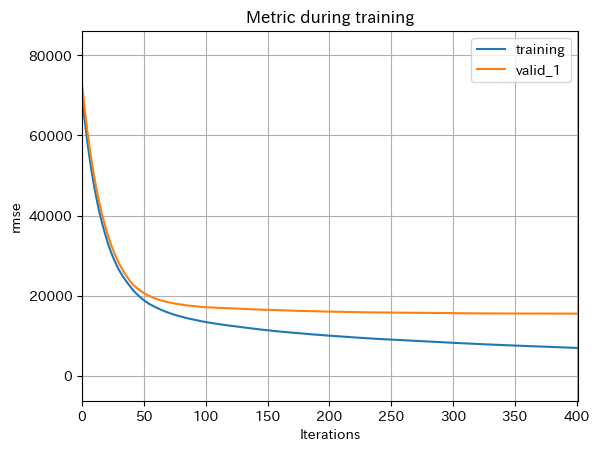

,importance
面積,4.544263e+14
L,3.945810e+14
平均地価,1.988177e+14
最寄り駅,9.456873e+13
築年数,6.761202e+13
所在地,4.004657e+13
全体の階数,2.967955e+13
一部屋あたりの面積,2.452531e+13
契約期間,1.292890e+13
所在階,1.153193e+13


In [25]:
n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  5.009615137983937e-06,
        'max_bin': 346,
        'num_leaves': 91,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

    pred_y_val = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

結局、「キッチン」はフルで入れて方が良いっぽい

### 20221005現在の特徴量群でやってみる！

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
building = pd.read_csv('../data/handmade_data/building.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over110m2 = pd.read_csv('../data/handmade_data/over110m2.csv')
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
over90m2 = pd.read_csv('../data/handmade_data/over90m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')
kitchen_points = pd.read_csv('../data/handmade_data/kitchen_points.csv')
equipments = pd.read_csv('../data/handmade_data/equipments.csv')
latitude_longitude = pd.read_csv('../data/handmade_data/latitude_longitude.csv')
broadcasts = pd.read_csv('../data/handmade_data/broadcasts.csv')
stations_te = pd.read_csv('../data/handmade_data/stations_te.csv')
age_x_minits = pd.read_csv('../data/handmade_data/age_x_minits.csv')
area_x_landprice = pd.read_csv('../data/handmade_data/area_x_landprice.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_building = pd.read_csv('../data/test_data/test_building.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over110m2 = pd.read_csv('../data/test_data/test_over110m2.csv')
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_over90m2 = pd.read_csv('../data/test_data/test_over90m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')
test_kitchen_points = pd.read_csv('../data/test_data/test_kitchen_points.csv')
test_equipments = pd.read_csv('../data/test_data/test_equipments.csv')
test_latitude_longitude = pd.read_csv('../data/test_data/test_latitude_longitude.csv')
test_broadcasts = pd.read_csv('../data/test_data/test_broadcasts.csv')
test_stations_te = pd.read_csv('../data/test_data/test_stations_te.csv')
test_age_x_minits = pd.read_csv('../data/test_data/test_age_x_minits.csv')
test_area_x_landprice = pd.read_csv('../data/test_data/test_area_x_landprice.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations_te, minits, land_aveprice, room_arrange[["部屋数","L","D","S"]], sepa_bath_toilets, buildings, over100m2, bt75and100m2, area_per_rooms, 
kitchen_points[['コンロ2口']], addresses, age_x_minits], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size,test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations_te, test_minits, test_land_aveprice, test_room_arrange[["部屋数","L","D",'S']],test_sepa_bath_toilets,test_buildings, test_over100m2, test_bt75and100m2, test_area_per_rooms, 
test_kitchen_points[['コンロ2口']], test_addresses, test_age_x_minits], axis=1)
category_lists = ['定期借家','最寄り駅', 'L', 'D','S', 'バス・トイレ別','建物構造','100m^2以上', '75m^2以上100m^2未満', 'コンロ2口','所在地']

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2977
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48937.5	valid_1's rmse: 50328.7
[20]	training's rmse: 34632.8	valid_1's rmse: 37953.2


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callback

[30]	training's rmse: 26239.3	valid_1's rmse: 31208.5
[40]	training's rmse: 21198.8	valid_1's rmse: 27337.1
[50]	training's rmse: 17956.7	valid_1's rmse: 24917.2
[60]	training's rmse: 16027.2	valid_1's rmse: 23397.1
[70]	training's rmse: 14665.8	valid_1's rmse: 22327.5
[80]	training's rmse: 13685.2	valid_1's rmse: 21626.9
[90]	training's rmse: 12939.2	valid_1's rmse: 21099.1
[100]	training's rmse: 12329.5	valid_1's rmse: 20678.9
[110]	training's rmse: 11860.8	valid_1's rmse: 20365.8
[120]	training's rmse: 11426	valid_1's rmse: 20051.8
[130]	training's rmse: 11067.6	valid_1's rmse: 19802
[140]	training's rmse: 10757.2	valid_1's rmse: 19563.6
[150]	training's rmse: 10473.4	valid_1's rmse: 19353.4
[160]	training's rmse: 10226.7	valid_1's rmse: 19182.5
[170]	training's rmse: 9950.06	valid_1's rmse: 18956.6
[180]	training's rmse: 9725.42	valid_1's rmse: 18794.6
[190]	training's rmse: 9491.4	valid_1's rmse: 18613.9
[200]	training's rmse: 9267.95	valid_1's rmse: 18485.8
[210]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callback

[40]	training's rmse: 22370.6	valid_1's rmse: 24674.1
[50]	training's rmse: 19505.4	valid_1's rmse: 22174.7
[60]	training's rmse: 17658	valid_1's rmse: 20819.3
[70]	training's rmse: 16332.3	valid_1's rmse: 19973.2
[80]	training's rmse: 15311.4	valid_1's rmse: 19446.4
[90]	training's rmse: 14508.6	valid_1's rmse: 19132.2
[100]	training's rmse: 13867.4	valid_1's rmse: 18910.2
[110]	training's rmse: 13340.3	valid_1's rmse: 18808.6
[120]	training's rmse: 12846.9	valid_1's rmse: 18734.6
[130]	training's rmse: 12380.7	valid_1's rmse: 18624.4
[140]	training's rmse: 11994.2	valid_1's rmse: 18557
[150]	training's rmse: 11627.3	valid_1's rmse: 18476.1
[160]	training's rmse: 11306.8	valid_1's rmse: 18409.4
[170]	training's rmse: 11004.4	valid_1's rmse: 18364.5
[180]	training's rmse: 10723.6	valid_1's rmse: 18344.1
[190]	training's rmse: 10476	valid_1's rmse: 18330
Early stopping, best iteration is:
[186]	training's rmse: 10570.9	valid_1's rmse: 18310.7
Start training...
[LightGBM] [Warning] Auto-

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callback

[20]	training's rmse: 35456.9	valid_1's rmse: 34598.2
[30]	training's rmse: 27291.6	valid_1's rmse: 27035
[40]	training's rmse: 22490.8	valid_1's rmse: 22839.7
[50]	training's rmse: 19527.4	valid_1's rmse: 20536.4
[60]	training's rmse: 17603.4	valid_1's rmse: 19488.3
[70]	training's rmse: 16285.5	valid_1's rmse: 18847.6
[80]	training's rmse: 15307.8	valid_1's rmse: 18481.9
[90]	training's rmse: 14492.7	valid_1's rmse: 18134.7
[100]	training's rmse: 13859.7	valid_1's rmse: 17911
[110]	training's rmse: 13299	valid_1's rmse: 17764.3
[120]	training's rmse: 12796	valid_1's rmse: 17583.2
[130]	training's rmse: 12351.6	valid_1's rmse: 17486.1
[140]	training's rmse: 11946.5	valid_1's rmse: 17404.6
[150]	training's rmse: 11584.3	valid_1's rmse: 17353.1
[160]	training's rmse: 11250.2	valid_1's rmse: 17285
[170]	training's rmse: 10927.9	valid_1's rmse: 17240.6
[180]	training's rmse: 10643.9	valid_1's rmse: 17211.2
[190]	training's rmse: 10395.4	valid_1's rmse: 17157.6
[200]	training's rmse: 10148

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callback

[10]	training's rmse: 49171.7	valid_1's rmse: 48131.6
[20]	training's rmse: 34810.5	valid_1's rmse: 35780.5
[30]	training's rmse: 26450.1	valid_1's rmse: 29130.4
[40]	training's rmse: 21662.5	valid_1's rmse: 25682.7
[50]	training's rmse: 18674.8	valid_1's rmse: 23949.2
[60]	training's rmse: 16771.8	valid_1's rmse: 22983.6
[70]	training's rmse: 15529.1	valid_1's rmse: 22460.4
[80]	training's rmse: 14653.6	valid_1's rmse: 22093.5
[90]	training's rmse: 13956.5	valid_1's rmse: 21742.3
[100]	training's rmse: 13375.1	valid_1's rmse: 21454.9
[110]	training's rmse: 12895.1	valid_1's rmse: 21256.6
[120]	training's rmse: 12490.6	valid_1's rmse: 21040.3
[130]	training's rmse: 12089.4	valid_1's rmse: 20857.7
[140]	training's rmse: 11754.2	valid_1's rmse: 20751.8
[150]	training's rmse: 11410.8	valid_1's rmse: 20564.9
[160]	training's rmse: 11093.4	valid_1's rmse: 20424.5
[170]	training's rmse: 10830	valid_1's rmse: 20335.1
[180]	training's rmse: 10549.6	valid_1's rmse: 20216.3
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49061	valid_1's rmse: 51586
[20]	training's rmse: 35413.1	valid_1's rmse: 37412
[30]	training's rmse: 27386.7	valid_1's rmse: 28914.8
[40]	training's rmse: 22744	valid_1's rmse: 23915.1
[50]	training's rmse: 19661	valid_1's rmse: 21094.2
[60]	training's rmse: 17680.4	valid_1's rmse: 19603.2
[70]	training's rmse: 16365.6	valid_1's rmse: 18710.8
[80]	training's rmse: 15362.6	valid_1's rmse: 18067
[90]	training's rmse: 14585.3	valid_1's rmse: 17755.1
[100]	training's rmse: 13972.6	valid_1's rmse: 1743

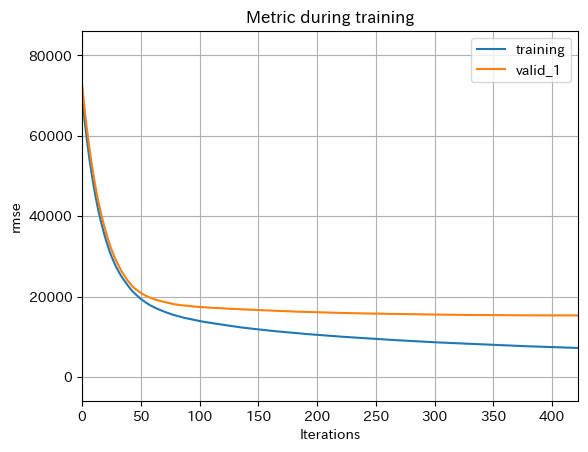

,importance
面積,4.677864e+14
L,3.760386e+14
平均地価,1.975774e+14
最寄り駅,9.493618e+13
築年数,5.515783e+13
所在地,4.338905e+13
全体の階数,3.105930e+13
一部屋あたりの面積,2.680520e+13
築年数＊所要時間,2.280864e+13
契約期間,1.394936e+13


In [36]:
n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  2.960577442860017e-06,
        'max_bin': 333,
        'num_leaves': 70,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

    pred_y_val = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

In [27]:
df = pd.read_csv('../data/outer_data/test.csv')
id = df['id']
y_pred = pd.DataFrame(y_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('../data/result_data/GBDT_cv_result.csv',index=False)

### StratifiedKFoldを使ってみる！

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
building = pd.read_csv('../data/handmade_data/building.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over110m2 = pd.read_csv('../data/handmade_data/over110m2.csv')
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
over90m2 = pd.read_csv('../data/handmade_data/over90m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')
kitchen_points = pd.read_csv('../data/handmade_data/kitchen_points.csv')
equipments = pd.read_csv('../data/handmade_data/equipments.csv')
latitude_longitude = pd.read_csv('../data/handmade_data/latitude_longitude.csv')
broadcasts = pd.read_csv('../data/handmade_data/broadcasts.csv')
stations_te = pd.read_csv('../data/handmade_data/stations_te.csv')
age_x_minits = pd.read_csv('../data/handmade_data/age_x_minits.csv')
area_x_landprice = pd.read_csv('../data/handmade_data/area_x_landprice.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_building = pd.read_csv('../data/test_data/test_building.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over110m2 = pd.read_csv('../data/test_data/test_over110m2.csv')
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_over90m2 = pd.read_csv('../data/test_data/test_over90m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')
test_kitchen_points = pd.read_csv('../data/test_data/test_kitchen_points.csv')
test_equipments = pd.read_csv('../data/test_data/test_equipments.csv')
test_latitude_longitude = pd.read_csv('../data/test_data/test_latitude_longitude.csv')
test_broadcasts = pd.read_csv('../data/test_data/test_broadcasts.csv')
test_stations_te = pd.read_csv('../data/test_data/test_stations_te.csv')
test_age_x_minits = pd.read_csv('../data/test_data/test_age_x_minits.csv')
test_area_x_landprice = pd.read_csv('../data/test_data/test_area_x_landprice.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, room_arrange[["部屋数","L","D","S"]], sepa_bath_toilets, buildings, over100m2, bt75and100m2, area_per_rooms, 
kitchen_points[['コンロ2口']], latitude_longitude[['平均緯度','平均経度']]], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size,test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_room_arrange[["部屋数","L","D",'S']],test_sepa_bath_toilets,test_buildings, test_over100m2, test_bt75and100m2, test_area_per_rooms, 
test_kitchen_points[['コンロ2口']], test_latitude_longitude[['平均緯度','平均経度']]], axis=1)
category_lists = ['定期借家','最寄り駅', 'L', 'D','S', 'バス・トイレ別','建物構造','100m^2以上', '75m^2以上100m^2未満', 'コンロ2口']

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argu

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2555
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118125.715642
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49313.1	valid_1's rmse: 49668.2
[20]	training's rmse: 35588.3	valid_1's rmse: 35794.6
[30]	training's rmse: 27367.2	valid_1's rmse: 27954.8
[40]	training's rmse: 22608.5	valid_1's rmse: 23406.8
[50]	training's rmse: 19695.1	valid_1's rmse: 20750.8
[60]	training's rmse: 17750.1	valid_1's rmse: 19388.4
[70]	training's rmse: 16521.8	valid_1's rmse: 18625.3
[80]	training's rmse: 15573.6	valid_1's rmse: 18223.1
[90]	training's rmse: 14831	valid_1's rmse: 17874.6
[100]	training's rmse: 14158.5	valid_1's 

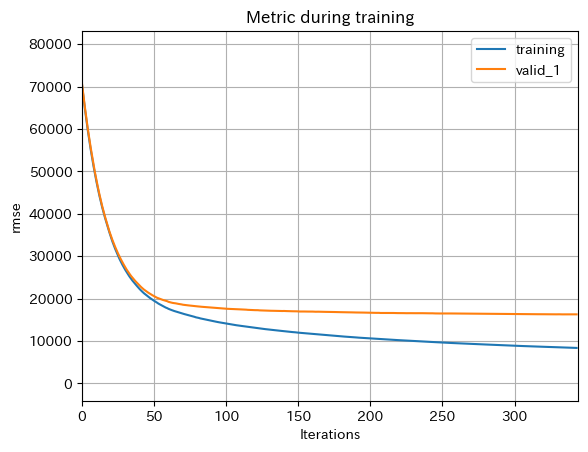

,importance
面積,4.880679e+14
L,3.746171e+14
平均地価,2.246246e+14
最寄り駅,9.767651e+13
築年数,6.442368e+13
全体の階数,3.143187e+13
一部屋あたりの面積,2.895095e+13
平均緯度,1.697999e+13
契約期間,1.515732e+13
所在階,9.574381e+12


In [26]:
from sklearn.model_selection import StratifiedKFold

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8, stratify=X_train['100m^2以上'])

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
params = {
    'objective':'regression',
    'boosting_type':'gbdt',
    'metrics':'rmse',
    'learning_rate':0.05,
    'reg_lambda':  2.960577442860017e-06,
    'max_bin': 333,
    'num_leaves': 70,
}

model = lgb.train(
                params,
                lgb_train, 
                valid_sets=[lgb_train, lgb_eval], 
                verbose_eval=10, 
                num_boost_round=1000, 
                early_stopping_rounds=10,
                categorical_feature = category_lists,
                evals_result=evals_result,
                )

pred_y_valid = model.predict(X_valid)
rmse = mean_squared_error(y_valid, pred_y_valid, squared=False)

print("whole valid rmse:", rmse)

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

In [18]:
df = pd.read_csv('../data/outer_data/test.csv')
id = df['id']
y_pred = pd.DataFrame(y_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('../data/result_data/GBDT_cv_result.csv',index=False,header=False)